This Jupyter notebook contains the code used to produce the figures in the paper "Characterizing the Multisectoral Impacts of Future Global Hydrologic Variability" by Birnbaum et al. currently under review.

Note: Figure 1 (schematic of stochastic watershed model procedure) was not made using code so is not included in the script.

* Figure 2: Determinic model (Xanthos) performance for Indus and Mekong basins
* Figure 3: Compare determinic and stochsatic model performance
* Figure 4: Stochastic model performance in historical period for Indus and Mekong basins
* Figure 5: Stochastic model performance in future period for Indus basin
* Figure 7: Basin-scale relative variability in water and agricultural sectors for all basins
* Figure 7: Assessing multisector impacts of basin-scale extreme runoff (high and low) in Indus basin

# Import Statements

Begin by importing the following relavent Python libraries/packages

In [1]:
#load in self-defined functions in stochastic_error_model.py and HydroVar_functions.py
from stochastic_error_model import *
from HydroVar_functions import *

# general useful packages
import time, os, math, random
import pandas as pd # data analysis
import numpy as np # numerical analysis
import geopandas as gpd # spatial analysis

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
#make text editable
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# modeling packages (stats and machine learning)
import statsmodels.api as sm
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

And also set the color palette used for most of the figures

In [2]:
# set color palette
cpal = sns.color_palette('Paired',12)

# Load in data for Figures 1 - 5

Next, load in the data used to run the stochastic model and produce figures 1-5 that evaluate model performance

In [3]:
#set path to data
#fpath = 'C:/Users/birnb/Documents/Tufts Research/GCIMS/birnbaum-etal_2024_HydroVariability/Data/'
fpath = 'C:/Users/abirnb01/Documents/Research/GCIMS/Paper2_HydroVariability/github_version/birnbaum-etal_2024_HydroVariability/Data/'
histfile = 'Runoff_data/hist_annual.csv'
futfile = 'Runoff_data/fut_annual_gfdl_ssp370.csv'

#set path for saving figures
spath = fpath+'Figures/'

#load in runoff data
df = pd.read_csv(fpath+histfile) #load in historical data
df_fut = pd.read_csv(fpath+futfile) #load in future data

#load in basin shapefiles
gcam_basins = gpd.read_file(fpath+'Shapefiles_for_mapping/gcam_basins.shp')
gcam_basins['basin_id'] = gcam_basins['sbRgnAl'].copy()

# Run Stochastic Model for 1000 simulations

In [4]:
m = 1000 # set number of stochastic realizations

[Q,sym,mineig_orig,mineig_new,pct_fro] = future_stoch_mvnorm(df,df_fut,m) #simulate stochastic realizations
Q[Q<0] = 0 # make sure there are no negative runoff values - set minimum to be zero for both historical and future

basin_nms = df.basin_name.unique() # get basin names
nbasins = len(basin_nms) # get # of basins
nyears = len(df['year'].unique()[:]) # get # of years

#get historical values
Q_hist = Q[:nyears,:,:]
q_ref = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                      (nyears,nbasins),order='F')
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                  (nyears,nbasins),order='F')

#get future values
Q_fut = Q[nyears:,:,:]
nfyears = len(df_fut.year.unique()) #length 
df_fut['q_fut'] = df_fut['q_fut'].astype(float)
q_fut = np.reshape(df_fut.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                      (nfyears,nbasins),order='F')


In [5]:
#check method

#are there any covariance matrices that aren't symmetric?
print('% covariance matrix that is symmetric: ',100*sum(sym)/(nyears+nfyears))

#what is minimum eigenvalue before "correction"?
print('min eigenvalue for a covariance matrix before "correction": ',np.min(mineig_orig))

#what is minimum eigenvalue after "correction"?
print('min eigenvalue for a covariance matrix after "correction": ',np.min(mineig_new))

#what is % of original frobenius norm made up by difference norm?
print('Mean % difference norm is of original covariance matrix: ',np.mean(pct_fro))

% covariance matrix that is symmetric:  100.0
min eigenvalue for a covariance matrix before "correction":  -2.887984085486247e-11
min eigenvalue for a covariance matrix after "correction":  2.369319551700957e-05
Mean % difference norm is of original covariance matrix:  0.04104364789250964


# Plots for Figure 2

Here, we look at model performance for determinisitc model: scatterplot of mean versus variance for all basins and flow duration curves for Indus and Mekong.

In [6]:
#calculate % error in mean and variance and correlation for stochastic ensemble

basin_nms = df['basin_name'].unique() #get list of basin names
basin_ids = df['basin_id'].unique() #get list of basin IDs

#empty storage arrays for mean (mu), variance (var), and correlation (rho)
mu_det = np.zeros(nbasins)
var_det = np.zeros(nbasins)
nse_det = np.zeros(nbasins)
rho_det = np.zeros(nbasins)
mu_stoch_median = np.zeros(nbasins)
var_stoch_median = np.zeros(nbasins)
nse_stoch_median = np.zeros(nbasins)
rho_stoch_median = np.zeros(nbasins)

#loop through basins
for j in range(nbasins):
    bsid = j+1 #basin ID
    df_basin = df[df.basin_id==bsid] # get deterministic model for that basin
    bsnm = df_basin.basin_name.iloc[0] #get basin's name
    boi_stoch = Q_hist[:,bsid-1,:] #get stochastic ensemble for that basin
    
    boi_obs = df_basin.q_obs.to_numpy() # reference runoff
    boi_det = df_basin.q_det.to_numpy() # deterministic model runoff
    
    #calculate percent error in mean
    mu_det[j] = 100*((np.mean(boi_det) - np.mean(boi_obs))/np.mean(boi_obs))
    
    #calculate percent error in variance
    var_det[j] = 100*((np.var(boi_det) - np.var(boi_obs))/np.var(boi_obs))
    
    #calculate NSE
    nse_det[j] = calc_NSE(boi_obs,boi_det)
    
    #calculate correlation with observed
    rho_det[j] = np.corrcoef(df_basin.q_obs,df_basin.q_det)[0,1]

    #stochastic - initialize empty arrays to store all realizations
    mu_stoch = np.zeros(m)
    var_stoch = np.zeros(m)
    nse_stoch = np.zeros(m)
    rho_stoch = np.zeros(m)
    for i in range(m):
        mu_stoch[i] = 100*((np.mean(boi_stoch[:,i]) - np.mean(boi_obs))/np.mean(boi_obs))
        var_stoch[i] = 100*((np.var(boi_stoch[:,i]) - np.var(boi_obs))/np.var(boi_obs))
        nse_stoch[i] = calc_NSE(boi_obs,boi_stoch[:,i])
        rho_stoch[i] = np.corrcoef(boi_obs,boi_stoch[:,i])[0,1]
    
    #median of stochastic
    mu_stoch_median[j] = np.median(mu_stoch)
    var_stoch_median[j] = np.median(var_stoch)
    nse_stoch_median[j] = np.median(nse_stoch)
    rho_stoch_median[j] = np.median(rho_stoch)
    
#create data frame of mdoel statistics (rho, delta, alpha)
model_stats = pd.DataFrame()
model_stats['basin_name'] = basin_nms
model_stats['basin_id'] = basin_ids
model_stats['mu_det'] = mu_det
model_stats['mu_stoch_median'] = mu_stoch_median
model_stats['var_det'] = var_det
model_stats['var_stoch_median'] = var_stoch_median
model_stats['nse_det'] = nse_det
model_stats['nse_stoch_median'] = nse_stoch_median
model_stats['rho_det'] = rho_det
model_stats['rho_stoch_median'] = rho_stoch_median

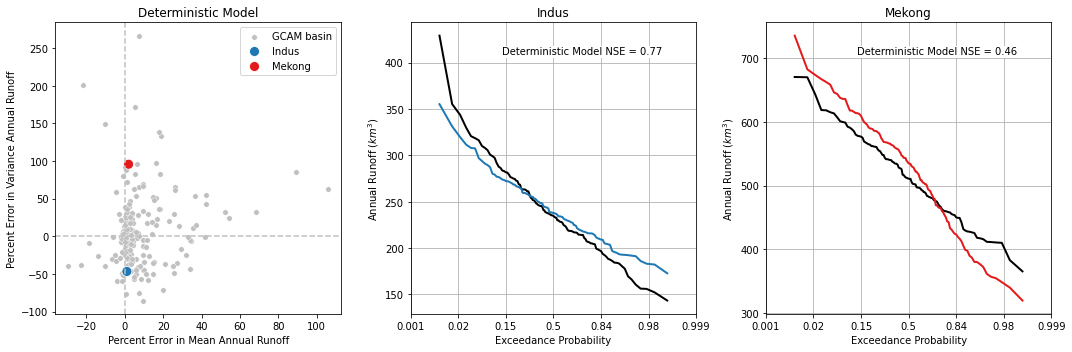

In [7]:
key_basins = ['Indus','Mekong'] # select basins to highlight
 
df_key = model_stats[model_stats.basin_name.isin(key_basins)] # create dataframe of these key basins
key_ids = df_key.basin_id.unique() #get basin ids for these key basins

clist = [cpal[1],cpal[5]] # set colors for plotting

#plot percent error mean versus percent error variance for deterministic
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5)) #initialize plot
ax1.axhline(0,color='silver',ls='--') # horizontal line at zero (ideal)
ax1.axvline(0,color='silver',ls='--') # vertical line at zero (ideal)
sns.scatterplot(ax=ax1,data=model_stats,x='mu_det',y='var_det',color='silver',s=30,label='GCAM basin') # plot all basins
ax1.legend(title='')
sns.scatterplot(ax=ax1,data=df_key,x='mu_det',y='var_det',hue='basin_name',palette=clist,
               hue_order=['Indus','Mekong'],s=100,legend=True) # plot key basins
ax1.set_xlabel('Percent Error in Mean Annual Runoff'); ax1.set_ylabel('Percent Error in Variance Annual Runoff')
ax1.legend(title=''); ax1.set_title('Deterministic Model')

#plot FDC for Indus (deterministic only)
bs_name = 'Indus'
bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1
df_basin = df[df.basin_name==bs_name] 
df_basin_fut = df_fut[df_fut.basin_name==bs_name]
det_nse = model_stats[model_stats.basin_name==bs_name]['nse_det'].iloc[0]
ax2 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[1],cpal[0],'hist_det',ax=ax2,)
ax2.text(0.6,0.9,'Deterministic Model NSE = '+str(round(det_nse,2)),bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1},
             ha='center',va='center',transform=ax2.transAxes)

#plot FDC for Mekong (deterministic only)
bs_name = 'Mekong'
bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1
df_basin = df[df.basin_name==bs_name] 
df_basin_fut = df_fut[df_fut.basin_name==bs_name]
det_nse = model_stats[model_stats.basin_name==bs_name]['nse_det'].iloc[0]
ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[5],cpal[0],'hist_det',ax=ax3,)
ax3.text(0.6,0.9,'Deterministic Model NSE = '+str(round(det_nse,2)),bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1},
             ha='center',va='center',transform=ax3.transAxes)
plt.tight_layout()
plt.savefig(spath+'Figure2.jpeg',dpi=300)
plt.savefig(spath+'Figure2.pdf')
#plt.close()

In [8]:
#how many basins have small error in mean for deterministic?
100*len(model_stats[abs(model_stats.mu_det)<20])/len(model_stats)

87.65957446808511

In [9]:
#how many basins have high variance for deterministic?
100*len(model_stats[abs(model_stats.var_det)>20])/len(model_stats)

52.765957446808514

In [10]:
#how many basins have low variance for deterministic?
100*len(model_stats[abs(model_stats.var_stoch_median)<5])/len(model_stats)

98.29787234042553

# Plots for Figure 3

Here, we look at model performance for stochastic model: scatterplot of mean versus variance for all basins and histogram of correlation with reference.

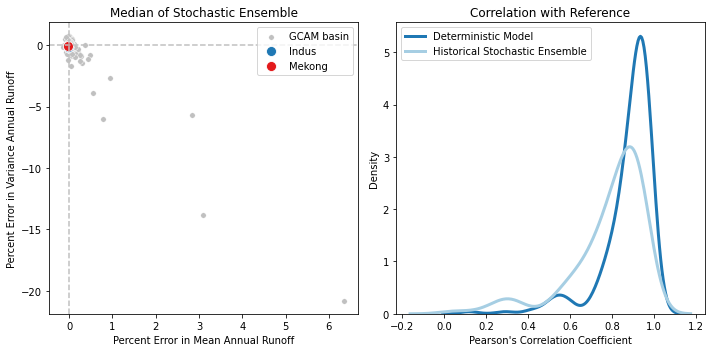

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

#now plot percent error mean versus percent error variance for median of stochastic ensemble
ax1.axhline(0,color='silver',ls='--') # horizontal line at zero (ideal)
ax1.axvline(0,color='silver',ls='--') # vertical line at zero (ideal)
sns.scatterplot(ax=ax1,data=model_stats,x='mu_stoch_median',y='var_stoch_median',color='silver',s=30,label='GCAM basin') # plot all basins
sns.scatterplot(ax=ax1,data=df_key,x='mu_stoch_median',y='var_stoch_median',hue='basin_name',palette=clist,
               hue_order=['Indus','Mekong'],s=100,legend=True) # plot key basins
ax1.legend(title='',loc='upper right')
ax1.set_xlabel('Percent Error in Mean Annual Runoff'); ax1.set_ylabel('Percent Error in Variance Annual Runoff')
ax1.set_title('Median of Stochastic Ensemble')

#now plot histograms of correlation across basins
sns.kdeplot(ax=ax2,data=model_stats,x='rho_det',color=cpal[1],alpha=1,label='Deterministic Model',lw=3)
sns.kdeplot(ax=ax2,data=model_stats,x='rho_stoch_median',color=cpal[0],alpha=1,label='Historical Stochastic Ensemble',lw=3)
ax2.legend(loc='upper left')
ax2.set_xlabel('Pearson\'s Correlation Coefficient'); ax2.set_ylabel('Density')
ax2.set_title('Correlation with Reference')

plt.tight_layout()
plt.savefig(spath+'Figure3.jpeg',dpi=300)
plt.savefig(spath+'Figure3.pdf')
#plt.close()

# Plots for Figure 4

Here we look at stochastic model performance in historical period for Indus and Mekong basins. Time series, scatterplots of mean versus variance, and flow duration curves.

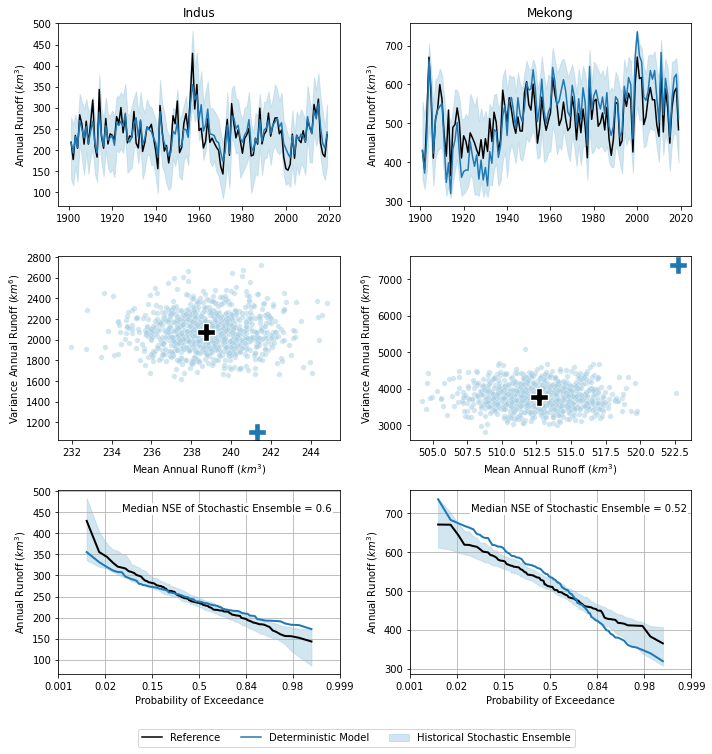

In [12]:
# results plots for a specific basin
fig,axes = plt.subplots(3,2,figsize=(10,10),gridspec_kw={'width_ratios': [1,1]})
axes = axes.flatten()
bs_name_list = ['Indus','Mekong']

#loop through basins
for i in range(len(bs_name_list)):
    
    bs_name = bs_name_list[i]
    bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1
    df_basin = df[df.basin_name==bs_name] 
    df_basin_fut = df_fut[df_fut.basin_name==bs_name]

    boi_obs = q_ref[:,bsid] #observed
    boi_det = q_det[:,bsid] #deterministic
    boi_stoch = Q_hist[:,bsid,:] #stochastic
    boi_fdet = q_fut[:,bsid]#future
    boi_fstoch = Q_fut[:,bsid,:]#future stochastic
    
    #get associated NSE for that basin
    det_nse = model_stats[model_stats.basin_name==bs_name]['nse_det'].iloc[0]
    stoch_nse = model_stats[model_stats.basin_name==bs_name]['nse_stoch_median'].iloc[0]
    
    # subplot 1: time series
    ax1 = axes[i]
    years = df.year.unique()[:]
    fyears = df_fut.year.unique()[:]
    sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Reference',color='k',legend=True)
    sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=True)
    ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5,label='Historical Stochastic Ensemble')
    ax1.set_ylabel('Annual Runoff ($km^3$)')
    ax1.tick_params(axis='both', which='major')
    ax1.set_title(bs_name)
    ax1.legend().set_visible(False)

    #second row is for scatterplots
    ax2 = axes[i+2]
    sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
    sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Reference',color='k',legend=False,marker='P')
    sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',color=cpal[1],legend=False,marker='P')
    ax2.set_xlabel('Mean Annual Runoff ($km^3$)')
    ax2.set_ylabel('Variance Annual Runoff ($km^6$)')
    ax2.tick_params(axis='both', which='major')
    
    #third row is for FDCs
    # subplot 3: probability of exceedance for future
    ax3 = axes[i+4]
    ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[1],cpal[0],'hist_stoch',ax=ax3,)
    ax3.set_xlabel('Probability of Exceedance')
    ax3.set_ylabel('Annual Runoff ($km^3$)')
    ax3.set_title('')
    ax3.tick_params(axis='both', which='major')
    ax3.legend().set_visible(False)
    #ax3.text(0.6,0.9,'Deterministic Model NSE = '+str(round(det_nse,2)),bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1},
    #         ha='center',va='center',transform=ax3.transAxes)
    ax3.text(0.6,0.9,'Median NSE of Stochastic Ensemble = '+str(round(stoch_nse,2)),bbox={'facecolor':'white', 'edgecolor':'none', 'pad':1},
             ha='center',va='center',transform=ax3.transAxes)
    
plt.tight_layout()
h, l = ax1.get_legend_handles_labels()
fig.legend(h[0:],l[0:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.05],ncol=3)
plt.savefig(spath+'Figure4.jpeg',dpi=300)
plt.savefig(spath+'Figure4.pdf')
#plt.close()

# Plots for Figure 5

Here we look at future model performance for Indus basin: time series, scatterplot of mean versus variance, and flow duration curve.

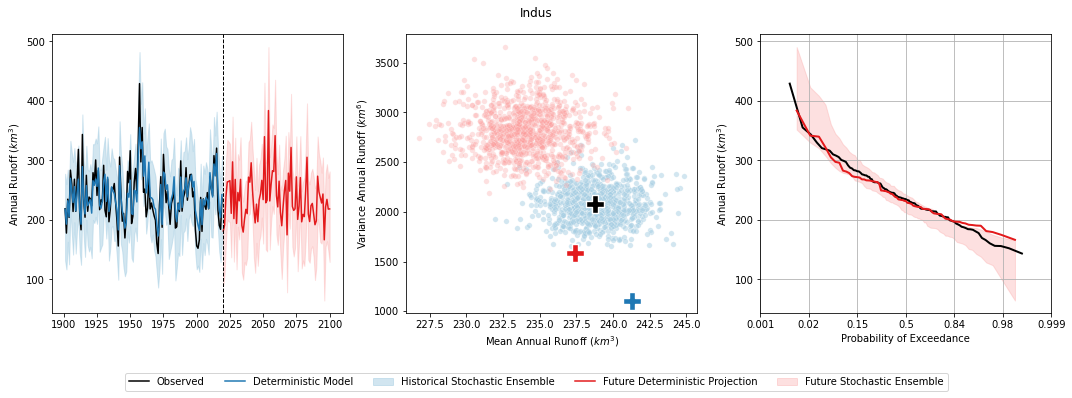

In [13]:
# results plots for a specific basin
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),
                                 gridspec_kw={'width_ratios': [1, 1,1]})

bs_name = 'Indus'
bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1

boi_obs = q_ref[:,bsid] #observed
boi_det = q_det[:,bsid] #deterministic
boi_stoch = Q_hist[:,bsid,:] #stochastic
boi_fdet = q_fut[:,bsid]#future
boi_fstoch = Q_fut[:,bsid,:]#future stochastic
df_basin = df[df.basin_name==bs_name] 
df_basin_fut = df_fut[df_fut.basin_name==bs_name]

# subplot 1: time series
years = df.year.unique()[:]
fyears = df_fut.year.unique()[:]
sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=False)
sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=False)
ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5,label='Historical Stochastic Ensemble')
sns.lineplot(ax=ax1,x=fyears,y=boi_fdet,label='Future Deterministic Projection',color=cpal[5],legend=False)
ax1.fill_between(fyears,np.min(boi_fstoch,axis=1),np.max(boi_fstoch,axis=1),color=cpal[4],alpha=0.3,label='Future Stochastic Ensemble')
ax1.axvline(years[-1]+0.5,color='k',lw=1,ls='--')
ax1.set_ylabel('Annual Runoff ($km^3$)')

# subplot 2: plot scatterplots of mean vs variance in annual runoff
sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,
                label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
sns.scatterplot(ax=ax2,x=np.mean(boi_fstoch,axis=0),y = np.var(boi_fstoch,axis=0),s=30,
                label='Future Stochastic Ensemble',color=cpal[4],legend=False,alpha=0.3)
sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Reference',color='k',legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',
                color=cpal[1],legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_fdet)],y=[np.var(boi_fdet)],s=300,label='Deterministic Projection',
                color=cpal[5],legend=False,marker='P')
ax2.set_xlabel('Mean Annual Runoff ($km^3$)')
ax2.set_ylabel('Variance Annual Runoff ($km^6$)')

# subplot 3: probability of exceedance for future
ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[5],cpal[0],'fut_stoch',ax3)
ax3.set_xlabel('Probability of Exceedance')
ax3.set_ylabel('Annual Runoff ($km^3$)')
ax3.set_title('')
ax3.legend().set_visible(False)

plt.suptitle(bs_name)
plt.tight_layout()

h, l = ax1.get_legend_handles_labels()
fig.legend(h[0:],l[0:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.1],ncol=5)
plt.savefig(spath+'Figure5.jpeg',dpi=300)
plt.savefig(spath+'Figure5.pdf')
#plt.close()

# Select scenarios to run through GCAM

To select scenarios to run through GCAM, we run the stochastic_error_model function for m=10,000. We then calculate cumulative runoff for 2070-2100 for the Indus basin and select 100 scenarios evenly spaced across the distribution. See supplement_figures.ipynb for code/figures related to this selection.

# Load in data for Figures 6-7.

We then run the 100 selected scenarios through GCAM. Replication instructions + code/data for the GCAM runs can be found on the GitHub repository for this paper. We query multiple quantities to explore the multisector impacts of variability in runoff, including water withdrawals, water price, max available runoff, land allocation by crop, crop production, primary energy consumption.

In [14]:
#load in shapefile of GCAM basins and clean it up
bc_map = pd.read_csv(fpath+'Shapefiles_for_mapping/basin_to_country_mapping.csv')
gcam_basins = gcam_basins.rename(columns={'sbRgnAl':'GCAM_basin_ID'}) #rename columns
bc_map = bc_map.rename(columns={'GLU_name':'basin'}) #rename columns in basin-country mapping
gcam_basins = gcam_basins.merge(bc_map,on=['GCAM_basin_ID']) #merge basins with basin-country mapping

#load in shapefile of GCAM regions
gcam_regions = gpd.read_file(fpath+'Shapefiles_for_mapping/gcam_regions.shp')

#total water withdrawals
ww = pd.read_pickle(fpath+'GCAM_queries/ww')
#groundwater withdrawals
ww_gw = pd.read_pickle(fpath+'GCAM_queries/ww_gw')
#surface water withdrawals
ww_sw = pd.read_pickle(fpath+'GCAM_queries/ww_sw')
#max available runoff
mr = pd.read_pickle(fpath+'GCAM_queries/mr')
#water price
wp = pd.read_pickle(fpath+'GCAM_queries/wp')
#water withdrawals for irrigation
ww_irrig = pd.read_pickle(fpath+'GCAM_queries/ww_irrig')
#basin-scale cropland, summed across crops
la = pd.read_pickle(fpath+'GCAM_queries/landalloc_sum')
#cropland allocation for Indus basin
la_indus = pd.read_pickle(fpath+'GCAM_queries/landalloc_indus')

Next, "clean up" these datasets by limiting to years 2015-2100 and only crops of interest (when applicable)  

In [15]:
#list of crops to include for crop production
crop_list = ['CornC4', 'FiberCrop', 'FodderGrass', 'FodderHerbC4', 'FodderHerb',
       'FruitsTree', 'Fruits', 'Legumes', 'MiscCropTree', 'MiscCrop',
       'NutsSeedsTree', 'NutsSeeds', 'OilCropTree', 'OilCrop',
       'OtherGrainC4', 'OtherGrain', 'Rice', 'RootTuber', 'Soybean',
       'SugarCropC4', 'SugarCrop', 'Vegetables', 'Wheat'] #took out biomassGrass and biomassTree

#list of crops to include for land allocation
la_croplist = ['CornC4', 'FiberCrop', 'FodderGrass', 'FodderHerb',
       'FruitsTree', 'Fruits', 'Legumes', 'MiscCropTree',
       'MiscCrop', 'NutsSeedsTree', 'NutsSeeds', 'OilCropTree', 'OilCrop',
       'OilPalmTree', 'OtherGrainC4', 'OtherGrain', 'Rice',
       'RootTuber', 'Soybean',
       'SugarCropC4', 'Vegetables', 'Wheat', 'FodderHerbC4', 'SugarCrop']
#removed  'Grassland', 'OtherArableLand','Pasture','ProtectedGrassland','Protected Shrubland',
#'ProtectedUnmanagedPasture','RockIceDesert','Shrubland','UnmanagedPasture',Tundra','UrbanLand',
#'biomassGrass','Forest','ProtectedUnmanagedForest','UnmanagedForest','biomassTree'

#set water withdrawals for irrigation to crops of interest and year >= 2015
ww_irrig = ww_irrig[(ww_irrig.crop.isin(crop_list)) & (ww_irrig.year>=2015)]

#set year>= 2015 for runoff, total water withdrawals, and surface water withdrawals 
mr = mr[(mr.year>=2015)]
ww = ww[(ww.year>=2015)]
sw = ww_sw[(ww_sw.year>=2015)]

#clean up cropland to get irrigated cropland
la = la.groupby(['scenario','Units','basin','year','irr_type'])['value'].sum().reset_index() #group across regions
la = la[la.year>=2020] #limit to 2020 and later
la_irr = la[la.irr_type=='IRR'] # just look at irrigated cropland

#create variables for global water withdrawals, primary energy, and ag production
ww_glob = ww.groupby(['scenario','Units','year'])['value'].sum().reset_index() #global water withdrawals

# Plots for Figure 6

Begin by calculating coefficient of variations for relevant quantities

In [16]:
#CV for total water withdrawals (by basin)
cv_ww_basin = ww.groupby(['year','basin'])['value'].std()/ww.groupby(['year','basin'])['value'].mean()
cv_ww_basin = cv_ww_basin.reset_index()

#CV for runoff (by basin)
cv_mr_basin = mr.groupby(['year','basin'])['value'].std()/mr.groupby(['year','basin'])['value'].mean()
cv_mr_basin = cv_mr_basin.reset_index()

#CV for surface water withdrawals (by basin)
cv_sw_basin = sw.groupby(['year','basin'])['value'].std()/sw.groupby(['year','basin'])['value'].mean()
cv_sw_basin = cv_sw_basin.reset_index()
cv_sw_basin = cv_sw_basin.rename(columns={'value':'value_sw'})

#CV for irrigated cropland (by basin)
cv_la_irr_basin = la_irr.groupby(['basin','year'])['value'].std()/la_irr.groupby(['basin','year'])['value'].mean()
cv_la_irr_basin = cv_la_irr_basin.reset_index()
cv_la_irr_basin = cv_la_irr_basin.rename(columns={'value':'value_la_irr'})

#merge CV for total water withdrawals, runoff, and surface water withdrawals
cv_basin = cv_ww_basin.merge(cv_mr_basin,on=['year','basin'],suffixes=['_ww','_mr'])
cv_basin = cv_basin.merge(cv_sw_basin,on=['year','basin'])
cv_basin = cv_basin.merge(cv_la_irr_basin,on=['year','basin'])
cv_basin = cv_basin.filter(['year','basin','value_ww','value_mr','value_sw','value_la_irr']) #filter to columns of interest

#create relative variability ratios, defined as CV quantity divided by CV runoff
cv_basin['ww_mr'] = cv_basin['value_ww']/cv_basin['value_mr'] #create column for ratio of total water withdrawals to runoff
cv_basin['sw_mr'] = cv_basin['value_sw']/cv_basin['value_mr'] #create column for ratio of surface water withdrawals to runoff
cv_basin['la_irr_mr'] = cv_basin['value_la_irr']/cv_basin['value_mr'] #create column for ratio of irrigated cropland to runoff

In [17]:
cv_basin[cv_basin.year==2100].sort_values(by='ww_mr',ascending=False).head(25)

,year,basin,value_ww,value_mr,value_sw,value_la_irr,ww_mr,sw_mr,la_irr_mr
3786,2100,SinaiP,0.355841,0.345630,0.302278,1.266420,1.029542,0.874571,3.664092
3696,2100,Iran,0.089344,0.091531,0.090333,0.067322,0.976107,0.986912,0.735511
3691,2100,IndCstE,0.031353,0.032673,0.031353,0.015532,0.959625,0.959625,0.475373
3645,2100,ChaoPhrR,0.080115,0.083953,0.080115,0.097254,0.954286,0.954286,1.158434
3654,2100,DeadSea,0.125956,0.134750,0.125956,0.125799,0.934734,0.934734,0.933568
3798,2100,TaptiR,0.024840,0.026821,0.024840,0.024477,0.926128,0.926128,0.912622
3644,2100,CauveryR,0.052578,0.056826,0.055444,0.047087,0.925248,0.975688,0.828623
3612,2100,AmuDaryaR,0.051510,0.056215,0.054293,0.030830,0.916291,0.965812,0.548419
3725,2100,MexCstNW,0.068544,0.076054,0.068575,0.056587,0.901262,0.901658,0.744034
3734,2100,NarmadaR,0.028836,0.032129,0.028836,0.017278,0.897487,0.897487,0.537779


Figure 6A is map of CV total water withdrawals divided by CV runoff in 2100

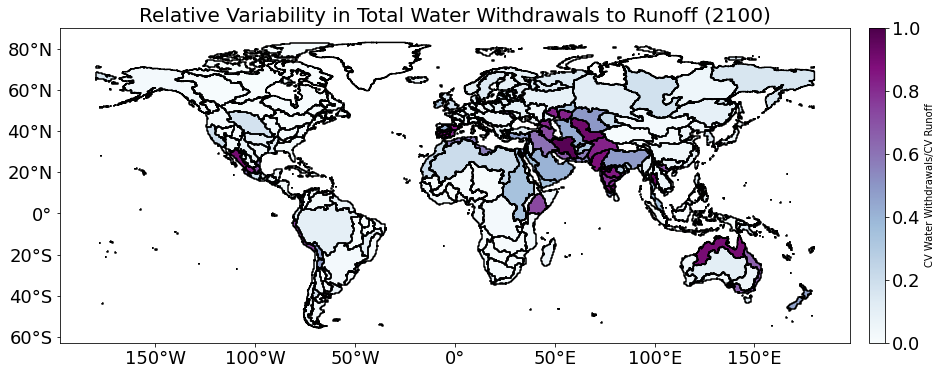

In [18]:
fig,(ax0) = plt.subplots(1,1,figsize=(15,10))

plot_df = cv_basin[cv_basin.year==2100] #limit to year 2100
plot_df = gcam_basins.merge(plot_df,on=['basin'])

divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='2%', pad=0.1)
gcam_basins.boundary.plot(ax=ax0,edgecolor='k')
plot_df.plot(column='ww_mr',ax=ax0,vmin=0,vmax=1,cmap='BuPu',legend=True,cax=cax,
            legend_kwds={'orientation':'vertical','label':'CV Water Withdrawals/CV Runoff'})
             
# #making latitude/longitude text labels smaller
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=14)
 #label maps with lat/lon coordinates
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=18)
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

ax0.set_title('Relative Variability in Total Water Withdrawals to Runoff (2100)',fontsize=20)
plt.savefig(spath+'Figure6_ww.png',dpi=300)
plt.savefig(spath+'Figure6_ww.pdf')
#plt.close()

Print out the 10 basins with the highest relative variability ratios for total water withdrawals/runoff

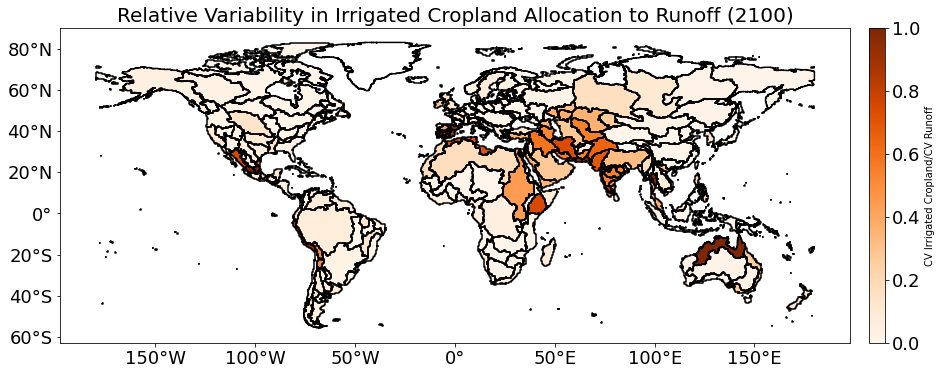

In [19]:
fig,(ax0) = plt.subplots(1,1,figsize=(15,10))

plot_df = cv_basin[cv_basin.year==2100] #limit to year 2100
plot_df = gcam_basins.merge(plot_df,on=['basin'])

divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='2%', pad=0.1)
gcam_basins.boundary.plot(ax=ax0,edgecolor='k')
plot_df.plot(column='la_irr_mr',ax=ax0,vmin=0,vmax=1,cmap='Oranges',legend=True,cax=cax,
            legend_kwds={'orientation':'vertical','label':'CV Irrigated Cropland/CV Runoff'})
             
# #making latitude/longitude text labels smaller
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=14)
 #label maps with lat/lon coordinates
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=18)
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

ax0.set_title('Relative Variability in Irrigated Cropland Allocation to Runoff (2100)',fontsize=20)
plt.savefig(spath+'Figure6_la.png',dpi=300)
plt.savefig(spath+'Figure6_la.pdf')
#plt.close()

In [20]:
cv_basin[cv_basin.year==2100].sort_values(by='la_irr_mr',ascending=False).head(20)

,year,basin,value_ww,value_mr,value_sw,value_la_irr,ww_mr,sw_mr,la_irr_mr
3786,2100,SinaiP,0.355841,0.345630,0.302278,1.266420,1.029542,0.874571,3.664092
3768,2100,RioLerma,0.089205,0.105876,0.089205,0.267145,0.842540,0.842540,2.523191
3662,2100,EbroR,0.157654,0.184302,0.157984,0.356009,0.855410,0.857202,1.931657
3694,2100,IndCstW,0.003885,0.006197,0.003885,0.010505,0.626947,0.626947,1.695304
3616,2100,ArabianSea,0.032719,0.061547,0.058416,0.088588,0.531607,0.949136,1.439361
3769,2100,RioVerde,0.045271,0.064803,0.045271,0.085096,0.698602,0.698602,1.313162
3645,2100,ChaoPhrR,0.080115,0.083953,0.080115,0.097254,0.954286,0.954286,1.158434
3796,2100,TagusR,0.046430,0.054168,0.046430,0.060038,0.857155,0.857155,1.108366
3622,2100,AusCstN,0.040270,0.044939,0.039629,0.048406,0.896094,0.881834,1.077144
3656,2100,DniesterR,0.069205,0.109756,0.069205,0.117234,0.630534,0.630534,1.068126


# Plots for Figure 7

In [21]:
ww_irrig_indus = ww_irrig[ww_irrig.basin=='IndusR'] #water withdrawals for irrigation
mr_indus = mr[(mr.basin=='IndusR')] #runoff
ww_sw_indus = ww_sw[(ww_sw.year>=2015) & (ww_sw.basin=='IndusR')] #surface water withdrawals
ww_indus = ww[(ww.year>=2015) & (ww.basin=='IndusR')] #total water withdrawals
wp_indus = wp[(wp.basin=='IndusR') & (wp.year>=2015)] #water price

# sum up irrigation water withdrawals across crop types
ww_irrig_indus_sum = ww_irrig_indus.groupby(['scenario','Units','year','basin'])['value'].sum().reset_index()

#clean up cropland allocation
la_indus = la_indus[la_indus.year>=2015] #limit to year>=2015
la_indus[['crop','basin','irr_type','fert_type']] = la_indus.landleaf.str.split('_',n=3,expand=True) 
la_indus = la_indus[(la_indus.crop.isin(la_croplist))] #limit to crops of interest
la_indus_sum = la_indus.groupby(['scenario','Units','year','irr_type'])['value'].sum().reset_index() #sum all crops
la_indus_irrig = la_indus_sum[la_indus_sum.irr_type=='IRR'] #sum irrigated crops
la_indus_rfd = la_indus_sum[la_indus_sum.irr_type=='RFD'] #sum rainfed crops

years = mr_indus.year.unique() #get years

Figure 7A is a time series 2015-2100 of relative variability in quantities of interest (surface water withdrawals, irrigated cropland, water price, water withdrawals for irrigation) to runoff for Indus basin

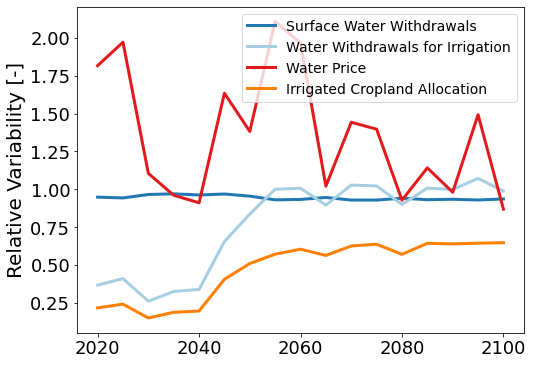

In [22]:
#calculate coefficient of variation for each quantity
cv_mr_indus = mr_indus.groupby(['year'])['value'].std()/mr_indus.groupby(['year'])['value'].mean() #runoff
cv_mr_indus = cv_mr_indus.reset_index()

cv_wp_indus = wp_indus.groupby(['year'])['value'].std()/wp_indus.groupby(['year'])['value'].mean() #water price
cv_wp_indus = cv_wp_indus.reset_index()

cv_sw_indus = ww_sw_indus.groupby(['year'])['value'].std()/ww_sw_indus.groupby(['year'])['value'].mean() #surface water withdrawals
cv_sw_indus = cv_sw_indus.reset_index()

cv_ww_irrig_indus = ww_irrig_indus_sum.groupby(['year'])['value'].std()/ww_irrig_indus_sum.groupby(['year'])['value'].mean() #irrigation water withdrawals
cv_ww_irrig_indus = cv_ww_irrig_indus.reset_index()

cv_la_irrig_indus = la_indus_irrig.groupby(['year'])['value'].std()/la_indus_irrig.groupby(['year'])['value'].mean() #irrigated cropland
cv_la_irrig_indus = cv_la_irrig_indus.reset_index()

#merge all CVs together
cv_indus1 = cv_wp_indus.merge(cv_sw_indus,on=['year'],suffixes=['_wp','_sw'])
cv_indus2 = cv_la_irrig_indus.merge(cv_ww_irrig_indus,on=['year'],suffixes=['_la_irrig','_ww_irrig'])
cv_indus = cv_indus1.merge(cv_indus2)
cv_indus = cv_indus.merge(cv_mr_indus,on=['year'])
cv_indus = cv_indus.rename(columns={'value':'value_mr'})
cv_indus = cv_indus[cv_indus.year>=2020] #limit to year 2020 and later

#get ratios of CV quantity to CV runoff
cv_indus_ratios = cv_indus.copy()
cv_indus_ratios['value_wp'] = cv_indus_ratios['value_wp']/cv_indus_ratios['value_mr']
cv_indus_ratios['value_ww_irrig'] = cv_indus_ratios['value_ww_irrig']/cv_indus_ratios['value_mr']
cv_indus_ratios['value_la_irrig'] = cv_indus_ratios['value_la_irrig']/cv_indus_ratios['value_mr']
cv_indus_ratios['value_sw'] = cv_indus_ratios['value_sw']/cv_indus_ratios['value_mr']

#plot CV ratios
fig,ax2 = plt.subplots(1,1,figsize=(8,6))
sns.lineplot(data=cv_indus_ratios,x='year',y='value_sw',color=cpal[1],lw=3,ax=ax2,label='Surface Water Withdrawals')
sns.lineplot(data=cv_indus_ratios,x='year',y='value_ww_irrig',color=cpal[0],lw=3,ax=ax2,label='Water Withdrawals for Irrigation')
sns.lineplot(data=cv_indus_ratios,x='year',y='value_wp',color=cpal[5],lw=3,ax=ax2,label='Water Price')
sns.lineplot(data=cv_indus_ratios,x='year',y='value_la_irrig',color=cpal[7],lw=3,ax=ax2,label='Irrigated Cropland Allocation')
ax2.set_xlabel('')
ax2.set_ylabel('Relative Variability [-]',fontsize=20)
#ax2.set_title('Indus')
ax2.legend([],[],frameon=False)
ax2.legend(loc='best',frameon=True,fontsize=14)
#plt.suptitle('Indus Basin')
plt.tick_params(axis='both', which='major', labelsize=18)
#ax2.legend(ncol=2,loc='lower center',fontsize=14,framealpha=1)
plt.savefig(spath+'Figure7_ts1.png',dpi=300)
plt.savefig(spath+'Figure7_ts1.pdf')
#plt.close()

Figure 7B shows time series of runoff 2015-2100 for Indus basin, median, low runoff, and high runoff scenarios are highlighted

Lowest Runoff in 2100


scenario    stochastic_runoff_76
Units                       km^3
year                        2100
value                    176.967
basin                     IndusR
Name: 379895, dtype: object

------------------------------
Highest Runoff in 2100


scenario    stochastic_runoff_51
Units                       km^3
year                        2100
value                    220.852
basin                     IndusR
Name: 242087, dtype: object

------------------------------
Median Runoff in 2100


scenario    stochastic_runoff_68
Units                       km^3
year                        2100
value                    200.318
basin                     IndusR
Name: 333959, dtype: object

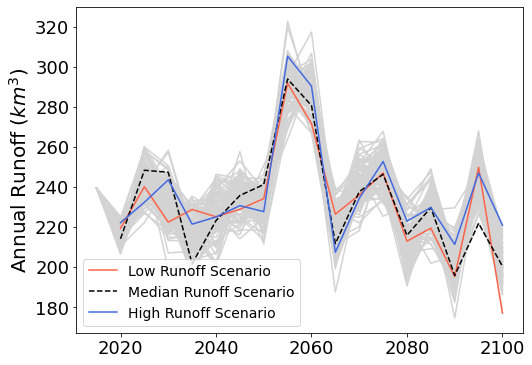

In [23]:
#begin by identifying which scenarios are the lowest, highest, and median

#lowest
print('Lowest Runoff in 2100')
display(mr_indus[mr_indus.year==2100].sort_values(by='value',ascending=True).iloc[0])
print('------------------------------')
#highest
print('Highest Runoff in 2100')
display(mr_indus[mr_indus.year==2100].sort_values(by='value',ascending=False).iloc[0])
print('------------------------------')
#median
print('Median Runoff in 2100')
display(mr_indus[mr_indus.year==2100].sort_values(by='value',ascending=False).iloc[49])

#plot
fig,axi = plt.subplots(1,1,figsize=(8,6))
years = mr_indus.year.unique()

sns.lineplot(data=mr_indus,x='year',y='value',color='lightgray',estimator=None,units='scenario')
sns.lineplot(data=mr_indus[(mr_indus.scenario=='stochastic_runoff_76') &
                          (mr_indus.year>=2020)],
            x='year',y='value',label='Low Runoff Scenario',color='tomato')
sns.lineplot(data=mr_indus[(mr_indus.scenario=='stochastic_runoff_68') &
                          (mr_indus.year>=2020)],
            x='year',y='value',label='Median Runoff Scenario',color='k',ls='--')
sns.lineplot(data=mr_indus[(mr_indus.scenario=='stochastic_runoff_51') &
                          (mr_indus.year>=2020)],
            x='year',y='value',label='High Runoff Scenario',color='royalblue')

axi.set_xlabel('')
axi.set_ylabel('Annual Runoff ($km^3$)',fontsize=20)
axi.legend([],[],frameon=False)
axi.legend(loc='lower left',frameon=True,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig(spath+'Figure6_ts2.png',dpi=300)
plt.savefig(spath+'Figure7_ts2.pdf')
#plt.close()

Figures 7C and 7D show maps of percent change in irrigated cropland in 2100 between the highest/lowest runoff scenarios and the median scenario

In [24]:
yr = 2100 #indicate which year we want to make these plots for

#load in CSV data of land allocation in these three scenarios (all basins)
la_worst = pd.read_csv(fpath+'GCAM_queries/land_alloc_75.csv')
la_best = pd.read_csv(fpath+'GCAM_queries/land_alloc_48.csv')
la_median = pd.read_csv(fpath+'GCAM_queries/land_alloc_66.csv')

#"clean up" data
la_crop = pd.concat([la_median,la_worst,la_best]) #merge the three scenarios
la_crop[['crop','basin','irr_type','fert_type']] = la_crop.landleaf.str.split('_',n=3,expand=True)
#select crops, year, and irrigated only
la_crop = la_crop[(la_crop.crop.isin(la_croplist)) & (la_crop.year==yr) & (la_crop.irr_type=='IRR')]
#sum across crops
la_crop_sum = la_crop.groupby(['Units','scenario','year','basin','irr_type'])['value'].sum().reset_index()

#calculate absolute difference between scenarios and median
la_crop_median = la_crop_sum[la_crop_sum.scenario=='stochastic_runoff_68']
la_crop_sum = la_crop_median.merge(la_crop_sum,on=['Units','year','basin','irr_type'],suffixes=['_median','_scenario'])
la_crop_sum['value_diff'] = la_crop_sum['value_scenario'] - la_crop_sum['value_median']
#calculate percent difference between scenarios and median
la_crop_sum['pct_diff'] = 100*((la_crop_sum['value_scenario'] - la_crop_sum['value_median'])/la_crop_sum['value_median'])

Make Figure 7C, difference between high runoff scenario and median

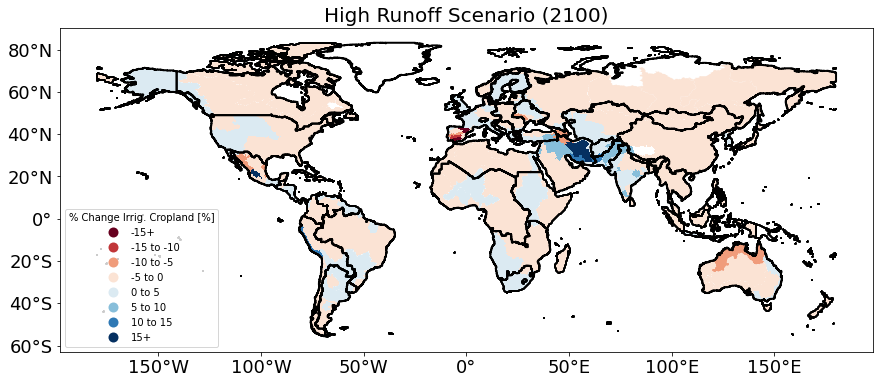

In [25]:
fig7c = la_crop_sum[(la_crop_sum.scenario_scenario=='stochastic_runoff_51')]
fig7c = gcam_basins.merge(fig7c,on=['basin'])

fig,(ax) = plt.subplots(1,1,figsize=(15,10))
divider = make_axes_locatable(ax)
fig7c.plot(column='pct_diff',ax=ax,cmap='RdBu',legend=True,scheme='user_defined',
             classification_kwds={'bins':[-15,-10,-5,0,5,10,15]},legend_kwds={'loc':'lower left','title':'Percent Difference'})
gcam_regions.boundary.plot(ax=ax,edgecolor='k',lw=2)

#make legend (https://stackoverflow.com/questions/74143732/customize-legend-labels-in-geopandas)
leg1 = ax.get_legend()
leg1.set_title('% Change Irrig. Cropland [%]')
new_legtxt = ['-15+','-15 to -10','-10 to -5','-5 to 0','0 to 5','5 to 10','10 to 15','15+'] 
for ix,eb in enumerate(leg1.get_texts()):
    eb.set_text(new_legtxt[ix])
    
#making latitude/longitude text labels smaller
#label maps with lat/lon coordinates
#https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax.tick_params(labelsize=18)

ax.set_title('High Runoff Scenario ('+str(yr)+')',fontsize=20)
plt.savefig(spath+'Figure7_high.png',dpi=300)
plt.savefig(spath+'Figure7_high.pdf')
#plt.close()

Make Figure 7D, difference between low runoff scenario and median

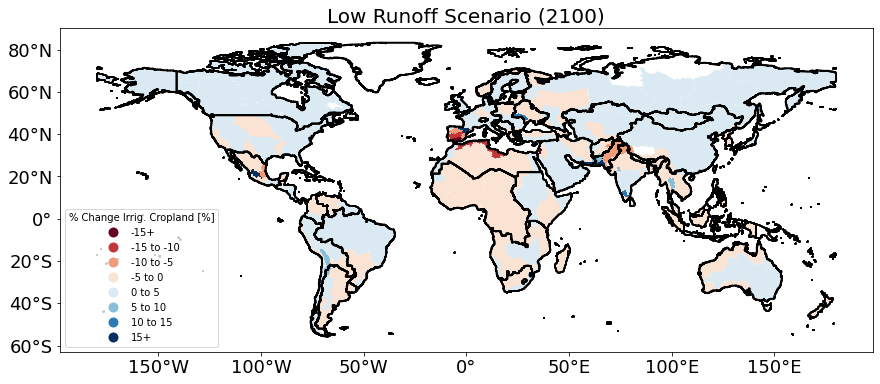

In [26]:
fig7d = la_crop_sum[(la_crop_sum.scenario_scenario=='stochastic_runoff_76')]
fig7d = gcam_basins.merge(fig7d,on=['basin'])
fig7d.loc[fig7d.pct_diff==-np.inf,'pct_diff'] = np.nan

fig,(ax) = plt.subplots(1,1,figsize=(15,10))
divider = make_axes_locatable(ax)
fig7d.plot(column='pct_diff',ax=ax,cmap='RdBu',legend=True,
                          scheme='user_defined',classification_kwds={'bins':[-15,-10,-5,0,5,10,15]},
            legend_kwds={'loc':'lower left'})
gcam_regions.boundary.plot(ax=ax,edgecolor='k',lw=2)

leg1 = ax.get_legend()
leg1.set_title('% Change Irrig. Cropland [%]')
new_legtxt = ['-15+','-15 to -10','-10 to -5','-5 to 0','0 to 5','5 to 10','10 to 15','15+'] 
for ix,eb in enumerate(leg1.get_texts()):
    eb.set_text(new_legtxt[ix])

#making latitude/longitude text labels smaller
#label maps with lat/lon coordinates
#https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax.tick_params(labelsize=18)

ax.set_title('Low Runoff Scenario ('+str(yr)+')',fontsize=20)
plt.savefig(spath+'Figure7_low.png',dpi=300)
plt.savefig(spath+'Figure7_low.pdf')
#plt.close()

In [27]:
#% change in Indus in low runoff scenario
la_crop_sum[(la_crop_sum.scenario_scenario=='stochastic_runoff_76') & (la_crop_sum.basin=='IndusR')]

,Units,scenario_median,year,basin,irr_type,value_median,scenario_scenario,value_scenario,value_diff,pct_diff
287,thous km2,stochastic_runoff_68,2100,IndusR,IRR,81.32184,stochastic_runoff_76,75.178091,-6.143748,-7.554857


In [28]:
##% change in Indus in high runoff scenario
la_crop_sum[(la_crop_sum.scenario_scenario=='stochastic_runoff_51') & (la_crop_sum.basin=='IndusR')]

,Units,scenario_median,year,basin,irr_type,value_median,scenario_scenario,value_scenario,value_diff,pct_diff
285,thous km2,stochastic_runoff_68,2100,IndusR,IRR,81.32184,stochastic_runoff_51,86.987418,5.665578,6.96686
